# **1. Perkenalan Dataset**


**Personalized Learning & Adaptive Education Dataset**

Dalam dunia pendidikan digital, memahami pola belajar siswa menjadi tantangan utama dalam menciptakan sistem pembelajaran adaptif. Dataset Personalized Learning & Adaptive Education ini dirancang untuk mendukung pengembangan model AI yang mampu mengelompokkan siswa berdasarkan pola keterlibatan dan performa mereka tanpa menggunakan label eksplisit.

Sumber Data: https://www.kaggle.com/datasets/adilshamim8/personalized-learning-and-adaptive-education-dataset/data

**Fitur Dataset**

Dataset ini mencakup berbagai aspek penting dari aktivitas siswa dalam platform pembelajaran online, termasuk:

- Interaksi dengan Konten: Waktu yang dihabiskan menonton video, jumlah percobaan kuis, dan keterlibatan dalam forum diskusi.

- Kinerja Akademik: Skor kuis, tingkat penyelesaian tugas, dan hasil ujian akhir.

- Profil & Preferensi Belajar: Usia, tingkat pendidikan, serta gaya belajar (Visual, Auditori, dll.).

**Pendekatan dalam Proyek**

Karena dataset ini tidak boleh memiliki label eksplisit saat klasifikasi, pendekatan yang digunakan adalah:

1. Clustering untuk Mengelompokkan Siswa

  - Menggunakan algoritma seperti K-Means, DBSCAN, atau Gaussian Mixture Model (GMM) untuk mengelompokkan siswa berdasarkan pola keterlibatan dan performa mereka.

  - Menentukan jumlah cluster optimal dengan metode seperti Silhouette Score atau Elbow Method.

  - Kolom Dropout Likelihood akan **dihapus** sebelum clustering agar tidak mempengaruhi hasil dan tetap mengikuti metode unsupervised learning.

2. Klasifikasi Berdasarkan Hasil Clustering

  - Setelah clustering selesai, hasilnya akan digunakan sebagai label baru untuk melatih model supervised seperti Random Forest, SVM, atau Neural Networks.

  - Model ini akan digunakan untuk memprediksi kelompok siswa baru berdasarkan pola yang telah ditemukan dalam clustering.

**Fitur yang Digunakan untuk Clustering**

Untuk memastikan clustering mencerminkan pola belajar siswa, fitur utama yang akan digunakan meliputi:
  - Engagement Metrics (Seberapa aktif siswa?) → Time Spent on Videos, Quiz Attempts, Forum Participation, Assignment Completion Rate
  - Performance Metrics (Seberapa baik performanya?) → Quiz Scores, Final Exam Score
  - Learning Preferences (Bagaimana gaya belajarnya?) → Learning Style
  - Demographics (Siapa mereka? Untuk analisis lebih lanjut) → Age, Education Level

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import umap
import seaborn as sns
import numpy as np

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/dataset/Personalized Learning/personalized_learning_dataset.csv')
df.head()

,Student_ID,Age,Gender,Education_Level,Course_Name,Time_Spent_on_Videos,Quiz_Attempts,Quiz_Scores,Forum_Participation,Assignment_Completion_Rate,Engagement_Level,Final_Exam_Score,Learning_Style,Feedback_Score,Dropout_Likelihood
0,S00001,15,Female,High School,Machine Learning,171,4,67,2,89,Medium,51,Visual,1,No
1,S00002,49,Male,Undergraduate,Python Basics,156,4,64,0,94,Medium,92,Reading/Writing,5,No
2,S00003,20,Female,Undergraduate,Python Basics,217,2,55,2,67,Medium,45,Reading/Writing,1,No
3,S00004,37,Female,Undergraduate,Data Science,489,1,65,43,60,High,59,Visual,4,No
4,S00005,34,Female,Postgraduate,Python Basics,496,3,59,34,88,Medium,93,Visual,3,No


**Menghapus Label (Dropout_Likelhood)**

In [4]:
df.drop(columns=['Dropout_Likelihood'], inplace=True)

In [5]:
df.head()

,Student_ID,Age,Gender,Education_Level,Course_Name,Time_Spent_on_Videos,Quiz_Attempts,Quiz_Scores,Forum_Participation,Assignment_Completion_Rate,Engagement_Level,Final_Exam_Score,Learning_Style,Feedback_Score
0,S00001,15,Female,High School,Machine Learning,171,4,67,2,89,Medium,51,Visual,1
1,S00002,49,Male,Undergraduate,Python Basics,156,4,64,0,94,Medium,92,Reading/Writing,5
2,S00003,20,Female,Undergraduate,Python Basics,217,2,55,2,67,Medium,45,Reading/Writing,1
3,S00004,37,Female,Undergraduate,Data Science,489,1,65,43,60,High,59,Visual,4
4,S00005,34,Female,Postgraduate,Python Basics,496,3,59,34,88,Medium,93,Visual,3


**Kolom Dropout Likelihood telah dihapus**

# **4. Exploratory Data Analysis (EDA)**

EDA bertujuan untuk memahami karakteristik dataset sebelum melakukan analisis lebih lanjut. Pada tahap ini, kita akan mengeksplorasi struktur data, distribusi data, korelasi antar variabel, serta karakteristik variabel numerik dan kategorikal menggunakan statistik deskriptif dan visualisasi.

## Struktur Data dan Missing Values

In [6]:
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")

Jumlah baris: 10000
Jumlah kolom: 14


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Student_ID                  10000 non-null  object
 1   Age                         10000 non-null  int64 
 2   Gender                      10000 non-null  object
 3   Education_Level             10000 non-null  object
 4   Course_Name                 10000 non-null  object
 5   Time_Spent_on_Videos        10000 non-null  int64 
 6   Quiz_Attempts               10000 non-null  int64 
 7   Quiz_Scores                 10000 non-null  int64 
 8   Forum_Participation         10000 non-null  int64 
 9   Assignment_Completion_Rate  10000 non-null  int64 
 10  Engagement_Level            10000 non-null  object
 11  Final_Exam_Score            10000 non-null  int64 
 12  Learning_Style              10000 non-null  object
 13  Feedback_Score              10000 non-null  int

Dataset ini terdiri dari **10.000 entri** dengan **14 kolom**, mencakup informasi demografi, keterlibatan, dan performa siswa dalam platform pembelajaran online.

- **Fitur Numerik (8 kolom)**: Usia, waktu belajar, jumlah percobaan kuis, skor kuis & ujian, partisipasi forum, tingkat penyelesaian tugas, dan skor umpan balik.

- **Fitur Kategorikal (6 kolom)**: Gender, tingkat pendidikan, nama kursus, tingkat keterlibatan, gaya belajar, dan ID siswa.

In [8]:
print("\nMissing values per kolom:")
print(df.isnull().sum())


Missing values per kolom:
Student_ID                    0
Age                           0
Gender                        0
Education_Level               0
Course_Name                   0
Time_Spent_on_Videos          0
Quiz_Attempts                 0
Quiz_Scores                   0
Forum_Participation           0
Assignment_Completion_Rate    0
Engagement_Level              0
Final_Exam_Score              0
Learning_Style                0
Feedback_Score                0
dtype: int64


Tidak ditemukan adanya missing values

## Distribusi Fitur Numerik

### Statistik Deskriptif Fitur Numerik

In [9]:
print(df.describe())

                Age  Time_Spent_on_Videos  Quiz_Attempts   Quiz_Scores  \
count  10000.000000          10000.000000   10000.000000  10000.000000   
mean      32.137700            255.375400       2.500500     64.578600   
std       10.062647            141.656392       1.122642     20.289125   
min       15.000000             10.000000       1.000000     30.000000   
25%       24.000000            131.000000       1.000000     47.000000   
50%       32.000000            257.000000       3.000000     65.000000   
75%       41.000000            378.000000       4.000000     82.000000   
max       49.000000            499.000000       4.000000     99.000000   

       Forum_Participation  Assignment_Completion_Rate  Final_Exam_Score  \
count         10000.000000                10000.000000      10000.000000   
mean             24.616200                   69.546800         64.697000   
std              14.330305                   17.360782         20.096417   
min               0.000000   

Dataset ini memiliki **8 fitur numerik**, masing-masing dengan distribusi berikut:

- **Age**: Usia siswa berkisar antara 15 hingga 49 tahun, dengan rata-rata 32 tahun.

- **Time Spent on Videos**: Rata-rata waktu belajar 255 menit, dengan rentang 10–499 menit.

- **Quiz Attempts**: Siswa mencoba kuis rata-rata 2-3 kali, dengan maksimum 4 kali.

- **Quiz Scores & Final Exam Score**: Skor kuis rata-rata 64,6%, sedangkan ujian akhir 64,7%, dengan skor tertinggi 99%.

- **Forum Participation**: Partisipasi rata-rata 24 posting, dengan siswa paling aktif mencapai 49 posting.

- **Assignment Completion Rate**: Sebagian besar siswa menyelesaikan 70% tugas, dengan beberapa hampir 100%.

- **Feedback Score**: Penilaian kursus rata-rata 3 dari 5, dengan variasi dari 1 hingga 5.

### Histogram untuk Distribusi Fitur Numerik

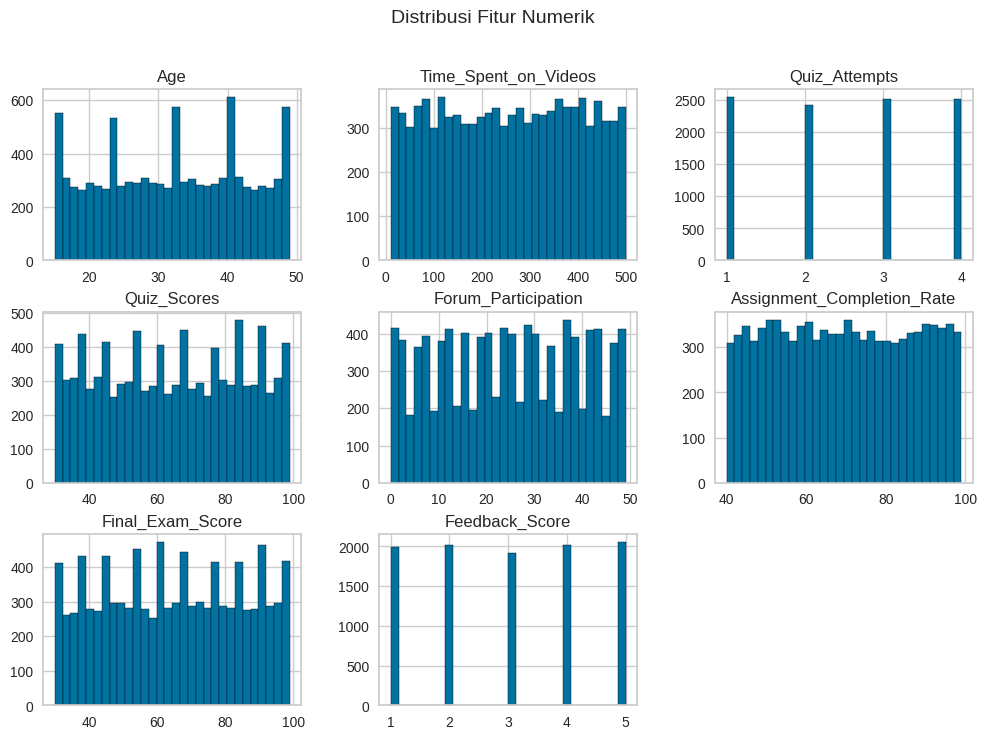

In [10]:
df.hist(figsize=(12, 8), bins=30, edgecolor="black")
plt.suptitle("Distribusi Fitur Numerik", fontsize=14)
plt.show()

### Boxplot untuk Deteksi Outlier

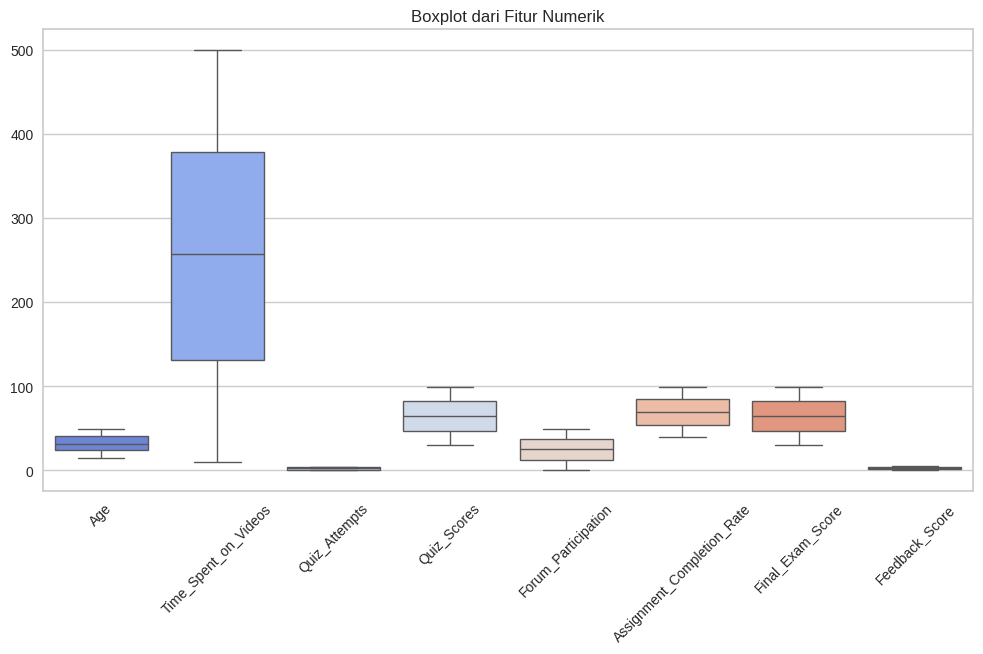

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Boxplot dari Fitur Numerik")
plt.show()

### Distribusi Setiap Fitur Numerik Secara Individual

#### Distribusi Usia

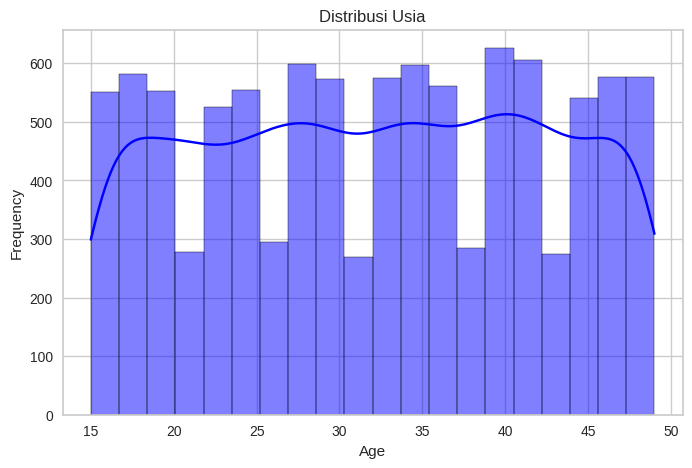

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(df["Age"], bins=20, kde=True, color="blue")
plt.title("Distribusi Usia")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

#### Distribusi Waktu yang Dihabiskan Menonton Video

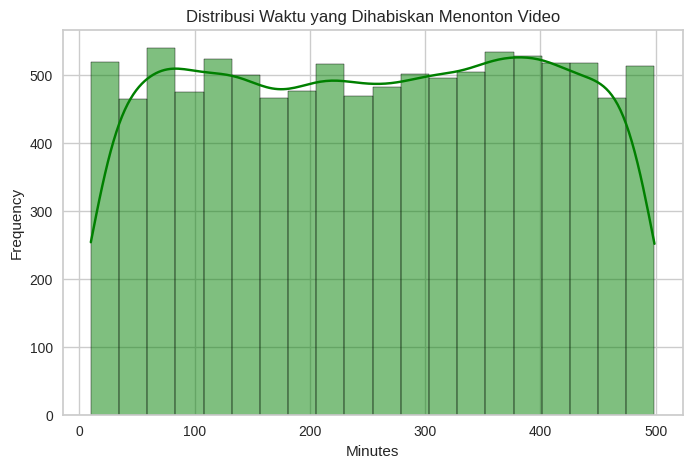

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(df["Time_Spent_on_Videos"], bins=20, kde=True, color="green")
plt.title("Distribusi Waktu yang Dihabiskan Menonton Video")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.show()

#### Distribusi Jumlah Percobaan Kuis

<ipython-input-14-17f10f8bf54d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Quiz_Attempts"], palette="pastel")


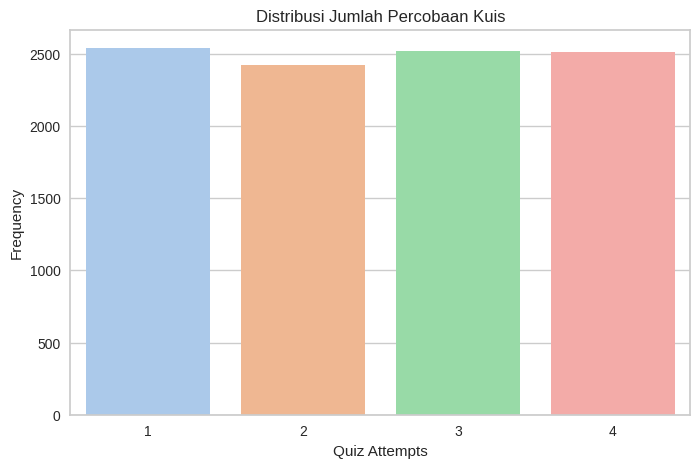

In [14]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Quiz_Attempts"], palette="pastel")
plt.title("Distribusi Jumlah Percobaan Kuis")
plt.xlabel("Quiz Attempts")
plt.ylabel("Frequency")
plt.show()

####Distribusi Skor Kuis

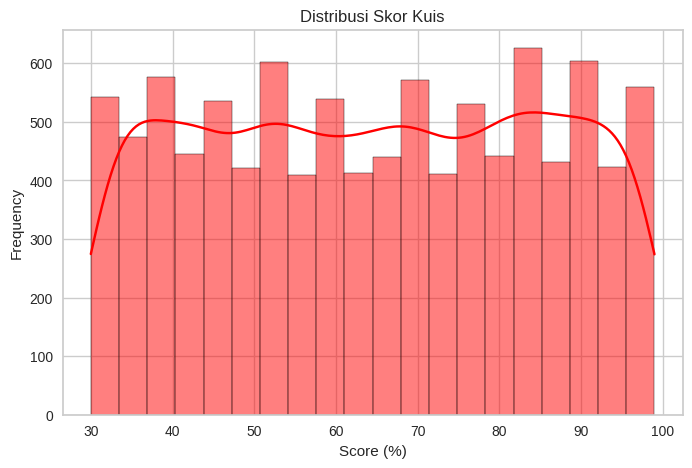

In [15]:
plt.figure(figsize=(8, 5))
sns.histplot(df["Quiz_Scores"], bins=20, kde=True, color="red")
plt.title("Distribusi Skor Kuis")
plt.xlabel("Score (%)")
plt.ylabel("Frequency")
plt.show()

#### Distribusi Partisipasi Forum

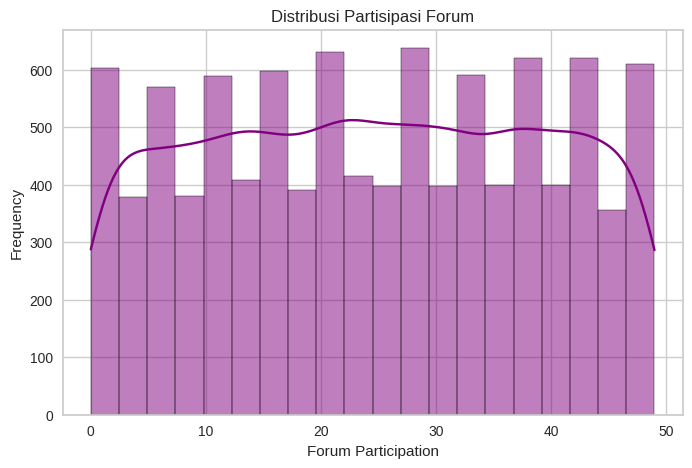

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(df["Forum_Participation"], bins=20, kde=True, color="purple")
plt.title("Distribusi Partisipasi Forum")
plt.xlabel("Forum Participation")
plt.ylabel("Frequency")
plt.show()

#### Distribusi Partisipasi Forum

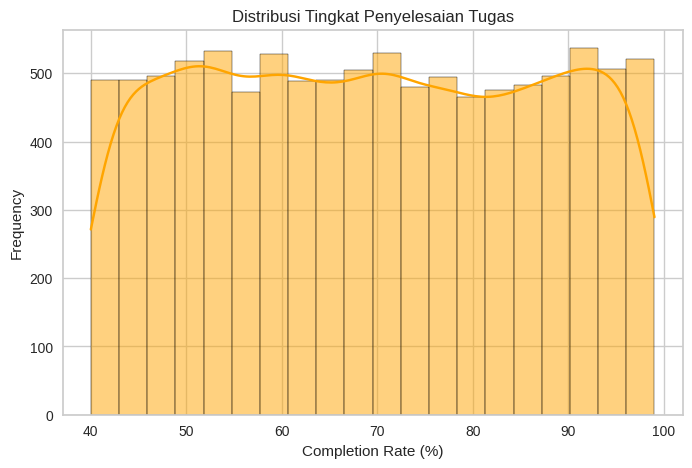

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(df["Assignment_Completion_Rate"], bins=20, kde=True, color="orange")
plt.title("Distribusi Tingkat Penyelesaian Tugas")
plt.xlabel("Completion Rate (%)")
plt.ylabel("Frequency")
plt.show()

#### Distribusi Skor Ujian Akhir

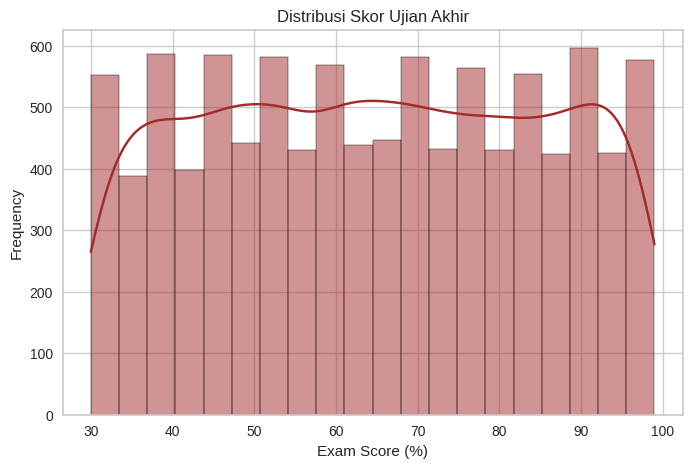

In [18]:
plt.figure(figsize=(8, 5))
sns.histplot(df["Final_Exam_Score"], bins=20, kde=True, color="brown")
plt.title("Distribusi Skor Ujian Akhir")
plt.xlabel("Exam Score (%)")
plt.ylabel("Frequency")
plt.show()

#### Distribusi Skor Umpan Balik

<ipython-input-19-f3a666722558>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Feedback_Score"], palette="coolwarm")


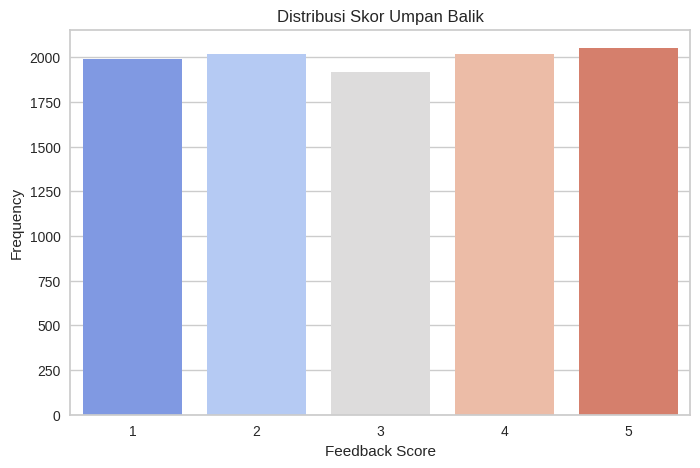

In [19]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Feedback_Score"], palette="coolwarm")
plt.title("Distribusi Skor Umpan Balik")
plt.xlabel("Feedback Score")
plt.ylabel("Frequency")
plt.show()

## Distribusi Fitur Kategorikal

Fitur kategorikal dalam dataset meliputi:

- Gender

- Education_Level

- Course_Name

- Engagement_Level

- Learning_Style

### Distribusi Gender

<ipython-input-20-4df845a318c5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Gender"], palette="pastel")


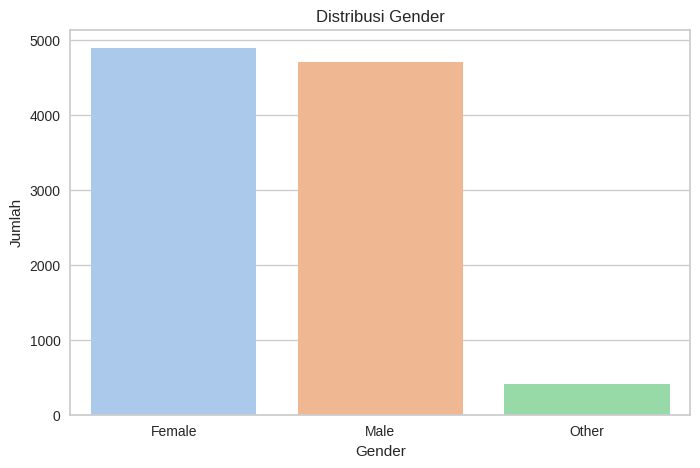

In [20]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Gender"], palette="pastel")
plt.title("Distribusi Gender")
plt.xlabel("Gender")
plt.ylabel("Jumlah")
plt.show()

### Distribusi Tingkat Pendidikan

<ipython-input-21-0010efb29ecd>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Education_Level"], palette="muted")


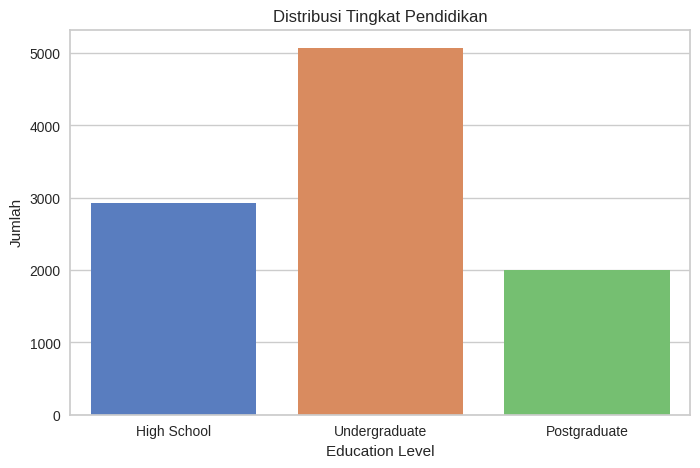

In [21]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Education_Level"], palette="muted")
plt.title("Distribusi Tingkat Pendidikan")
plt.xlabel("Education Level")
plt.ylabel("Jumlah")
plt.show()

### Distribusi Course yang Diambil

<ipython-input-22-7e4978259a5e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["Course_Name"], palette="coolwarm")


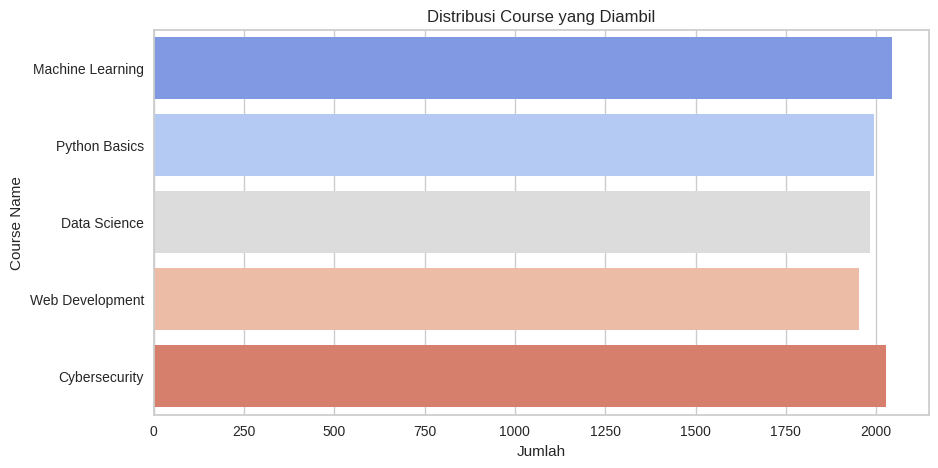

In [22]:
plt.figure(figsize=(10, 5))
sns.countplot(y=df["Course_Name"], palette="coolwarm")
plt.title("Distribusi Course yang Diambil")
plt.xlabel("Jumlah")
plt.ylabel("Course Name")
plt.show()

### Distribusi Engagement Level

<ipython-input-23-7ba998854cbe>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Engagement_Level"], palette="cool")


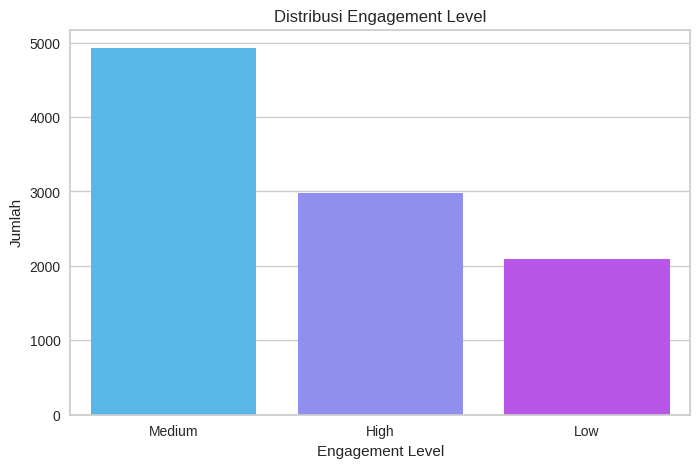

In [23]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Engagement_Level"], palette="cool")
plt.title("Distribusi Engagement Level")
plt.xlabel("Engagement Level")
plt.ylabel("Jumlah")
plt.show()

### Distribusi Learning Style

<ipython-input-24-5b256b7480b2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Learning_Style"], palette="coolwarm")


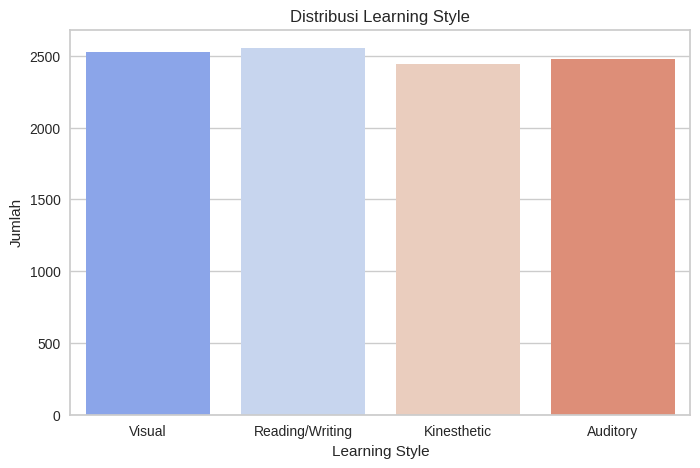

In [24]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Learning_Style"], palette="coolwarm")
plt.title("Distribusi Learning Style")
plt.xlabel("Learning Style")
plt.ylabel("Jumlah")
plt.show()

## Korelasi antar variabel

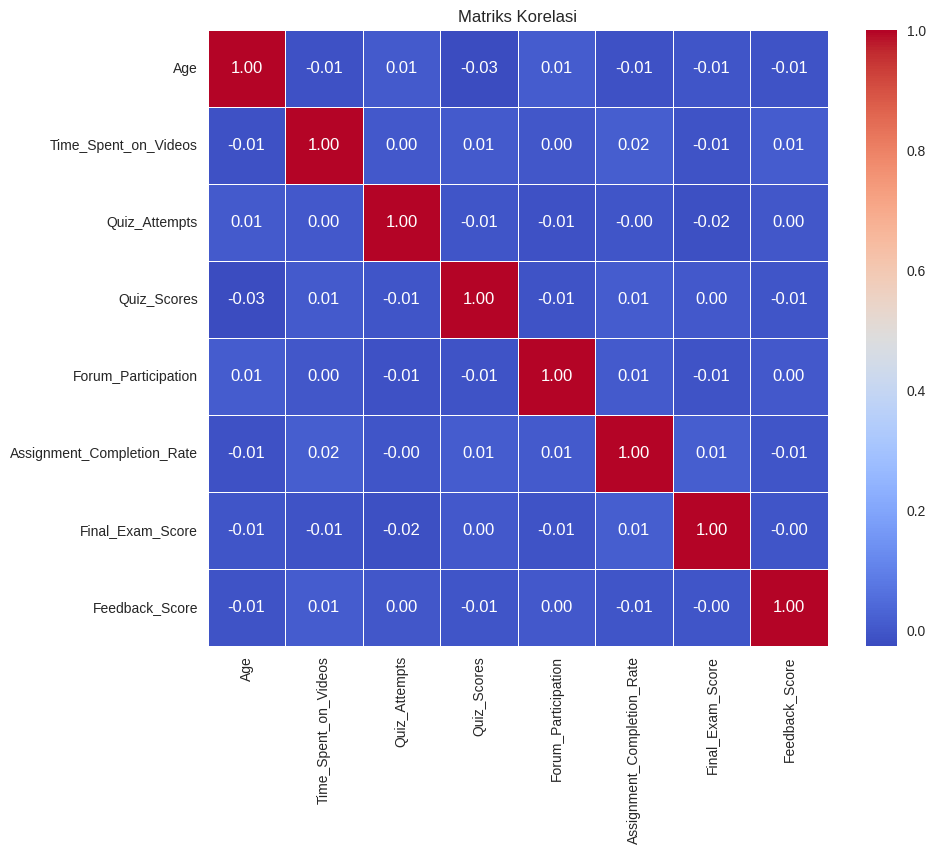

In [25]:
numerical_features = df.select_dtypes(include=['number'])

plt.figure(figsize=(10, 8))
sns.heatmap(numerical_features.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriks Korelasi")
plt.show()

# **5. Data Preprocessing**

Tahap ini bertujuan untuk membersihkan, mempersiapkan, dan menyusun data agar siap digunakan dalam model clustering.

Tahapan Data Preprocessing:
- Menangani Missing Values
- Menghapus Data Duplikat
- Encoding Data Kategorikal
- Deteksi dan Penanganan Outlier
- Binning pada Fitur Tertentu
- Normalisasi atau Standarisasi Fitur Numerik

In [26]:
# Drop Student_ID karena tidak relevan
df = df.drop(columns=["Student_ID"])

## Menangani Missing Values

In [27]:
print(df.isnull().sum())

Age                           0
Gender                        0
Education_Level               0
Course_Name                   0
Time_Spent_on_Videos          0
Quiz_Attempts                 0
Quiz_Scores                   0
Forum_Participation           0
Assignment_Completion_Rate    0
Engagement_Level              0
Final_Exam_Score              0
Learning_Style                0
Feedback_Score                0
dtype: int64


Tidak ditemukan adanya missing values.

### Menghapus Data Duplikat

In [28]:
print(f"Jumlah data duplikat: {df.duplicated().sum()}")

Jumlah data duplikat: 0


Tidak ditemukan adanya data duplikat.

## Encoding Data Kategorikal

Fitur kategorikal yang perlu diubah menjadi numerik:

- Gender

- Education_Level

- Course_Name

- Engagement_Level

- Learning_Style

In [29]:
df = pd.get_dummies(df, columns=["Gender", "Education_Level", "Course_Name", "Engagement_Level", "Learning_Style"], drop_first=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Age                             10000 non-null  int64
 1   Time_Spent_on_Videos            10000 non-null  int64
 2   Quiz_Attempts                   10000 non-null  int64
 3   Quiz_Scores                     10000 non-null  int64
 4   Forum_Participation             10000 non-null  int64
 5   Assignment_Completion_Rate      10000 non-null  int64
 6   Final_Exam_Score                10000 non-null  int64
 7   Feedback_Score                  10000 non-null  int64
 8   Gender_Male                     10000 non-null  bool 
 9   Gender_Other                    10000 non-null  bool 
 10  Education_Level_Postgraduate    10000 non-null  bool 
 11  Education_Level_Undergraduate   10000 non-null  bool 
 12  Course_Name_Data Science        10000 non-null  bool 
 13  Co

## Deteksi dan Penanganan Outlier
Menggunakan Interquartile Range (IQR) untuk mendeteksi dan menghapus outlier pada fitur numerik:

In [31]:
# Pilih hanya kolom numerik
numerical_columns = df.select_dtypes(include=['number'])

# Hitung Q1 (25%) dan Q3 (75%) untuk setiap fitur numerik
Q1 = numerical_columns.quantile(0.25)
Q3 = numerical_columns.quantile(0.75)
IQR = Q3 - Q1

# Identifikasi outlier: data yang berada di luar batas IQR
outlier_condition = (numerical_columns < (Q1 - 1.5 * IQR)) | (numerical_columns > (Q3 + 1.5 * IQR))
outliers = numerical_columns[outlier_condition.any(axis=1)]

# Jumlah outlier
num_outliers = len(outliers)
print(f"Jumlah outlier: {num_outliers}")

Jumlah outlier: 0


Tidak Terdeteksi adanya Outlier.

## Binning pada Fitur Tertentu
Beberapa fitur dapat dikelompokkan dalam kategori untuk analisis lebih lanjut:

###Binning pada Age (Kelompok Usia)
Mengubah usia ke dalam kategori:

- Teenager (15-20 tahun)

- Young Adult (21-30 tahun)

- Adult (31-40 tahun)

- Senior (41-50 tahun)

In [32]:
bins = [15, 20, 30, 40, 50]
labels = ["Teenager", "Young Adult", "Adult", "Senior"]
df["Age_Group"] = pd.cut(df["Age"], bins=bins, labels=labels)

### Binning pada Quiz_Scores dan Final_Exam_Score
Mengelompokkan performa ujian menjadi:

- Low (≤50%)

- Medium (51-75%)

- High (>75%)

In [33]:
bins = [0, 50, 75, 100]
labels = ["Low", "Medium", "High"]

df["Quiz_Performance"] = pd.cut(df["Quiz_Scores"], bins=bins, labels=labels)
df["Final_Exam_Performance"] = pd.cut(df["Final_Exam_Score"], bins=bins, labels=labels)

### Binning pada Time_Spent_on_Videos (Durasi Belajar)
Mengelompokkan waktu menonton video ke dalam kategori:

- Very Short (<100 menit)

- Short (100-200 menit)

- Medium (201-300 menit)

- Long (301-400 menit)

- Very Long (>400 menit)


In [34]:
bins = [0, 100, 200, 300, 400, 500]
labels = ["Very Short", "Short", "Medium", "Long", "Very Long"]
df["Video_Watching_Habit"] = pd.cut(df["Time_Spent_on_Videos"], bins=bins, labels=labels)

### Encoding Kategori Hasil Binning
Setelah binning, kita harus mengubah kategori ke dalam bentuk numerik agar bisa digunakan dalam clustering.

In [35]:
df = pd.get_dummies(df, columns=["Age_Group", "Quiz_Performance", "Final_Exam_Performance", "Video_Watching_Habit"], drop_first=True)

## Normalisasi atau Standarisasi Fitur Numerik
Clustering sangat bergantung pada skala data, sehingga kita menggunakan Min-Max Scaling untuk fitur numerik:

In [36]:
# Get numerical features from updated df
numerical_features = df.select_dtypes(include=['number']).columns

# Now use this updated list of numerical features for scaling
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Save scaler for later use
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [37]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             10000 non-null  float64
 1   Time_Spent_on_Videos            10000 non-null  float64
 2   Quiz_Attempts                   10000 non-null  float64
 3   Quiz_Scores                     10000 non-null  float64
 4   Forum_Participation             10000 non-null  float64
 5   Assignment_Completion_Rate      10000 non-null  float64
 6   Final_Exam_Score                10000 non-null  float64
 7   Feedback_Score                  10000 non-null  float64
 8   Gender_Male                     10000 non-null  bool   
 9   Gender_Other                    10000 non-null  bool   
 10  Education_Level_Postgraduate    10000 non-null  bool   
 11  Education_Level_Undergraduate   10000 non-null  bool   
 12  Course_Name_Data Science        1

,Age,Time_Spent_on_Videos,Quiz_Attempts,Quiz_Scores,Forum_Participation,Assignment_Completion_Rate,Final_Exam_Score,Feedback_Score
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.504050,0.501790,0.500167,0.501139,0.502371,0.500793,0.502855,0.503150
std,0.295960,0.289686,0.374214,0.294045,0.292455,0.294251,0.291252,0.355356
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.264706,0.247444,0.000000,0.246377,0.244898,0.237288,0.246377,0.250000
50%,0.500000,0.505112,0.666667,0.507246,0.510204,0.491525,0.507246,0.500000
75%,0.764706,0.752556,1.000000,0.753623,0.755102,0.762712,0.753623,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# **6. Pembangunan Model Clustering**

Load Data

In [38]:
df_cluster = df.copy()

## **a. Pembangunan Model Clustering**

In [39]:
# Bangun model Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=4, linkage='ward')
df_cluster["Cluster_Agglo"] = agglo.fit_predict(df_cluster)

# Lihat hasil clustering
print(df_cluster.groupby("Cluster_Agglo").mean())

                    Age  Time_Spent_on_Videos  Quiz_Attempts  Quiz_Scores  \
Cluster_Agglo                                                               
0              0.386688              0.407343       0.495542     0.355173   
1              0.854282              0.433529       0.507049     0.480011   
2              0.391771              0.455940       0.490349     0.779903   
3              0.486580              0.872191       0.515768     0.481628   

               Forum_Participation  Assignment_Completion_Rate  \
Cluster_Agglo                                                    
0                         0.503926                    0.498370   
1                         0.506646                    0.489893   
2                         0.496410                    0.503040   
3                         0.501564                    0.517213   

               Final_Exam_Score  Feedback_Score  Gender_Male  Gender_Other  \
Cluster_Agglo                                                 

## b. Evaluasi Model Clustering

### Dendogram

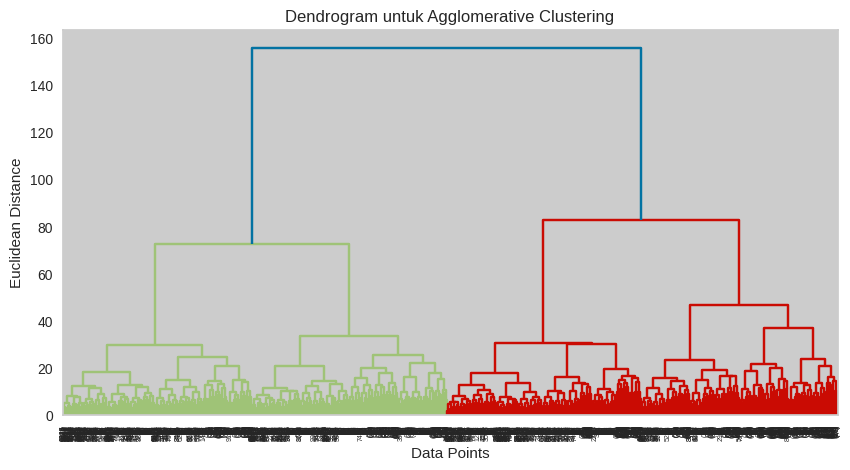

In [40]:
# Dendrogram untuk menentukan jumlah cluster optimal
linked = linkage(df_cluster, method="ward")

plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode="level", p=10)
plt.title("Dendrogram untuk Agglomerative Clustering")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

### Silhouette Score

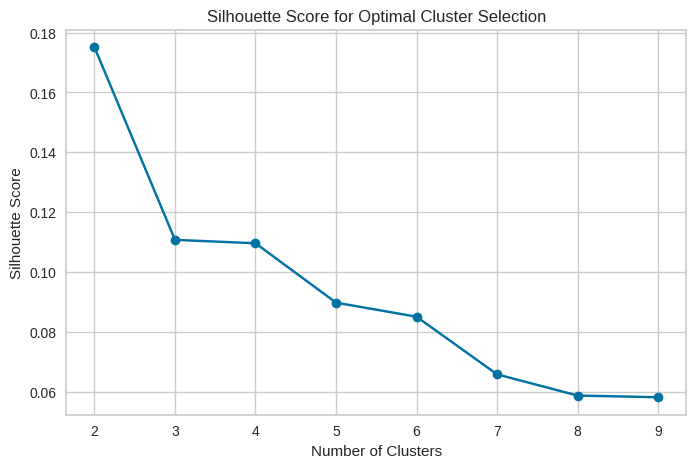

In [41]:
# Uji berbagai jumlah cluster untuk mencari yang terbaik berdasarkan Silhouette Score
silhouette_scores = []
cluster_range = range(2, 10)  # Coba jumlah cluster dari 2 sampai 10

for n_clusters in cluster_range:
    agglo_test = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    labels = agglo_test.fit_predict(df_cluster)
    silhouette_avg = silhouette_score(df_cluster, labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker="o", linestyle="-")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal Cluster Selection")
plt.show()

In [42]:
# Hitung silhouette score
silhouette_agglo = silhouette_score(df_cluster, df_cluster['Cluster_Agglo'])
print(f"Silhouette Score Agglomerative: {silhouette_agglo}")

Silhouette Score Agglomerative: 0.10959159588473415


## **c. Feature Selection**

In [43]:
# Cek kembali struktur data
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             10000 non-null  float64
 1   Time_Spent_on_Videos            10000 non-null  float64
 2   Quiz_Attempts                   10000 non-null  float64
 3   Quiz_Scores                     10000 non-null  float64
 4   Forum_Participation             10000 non-null  float64
 5   Assignment_Completion_Rate      10000 non-null  float64
 6   Final_Exam_Score                10000 non-null  float64
 7   Feedback_Score                  10000 non-null  float64
 8   Gender_Male                     10000 non-null  bool   
 9   Gender_Other                    10000 non-null  bool   
 10  Education_Level_Postgraduate    10000 non-null  bool   
 11  Education_Level_Undergraduate   10000 non-null  bool   
 12  Course_Name_Data Science        1

### Analisis Pengaruh Fitur terhadap Cluster

In [44]:
# Pisahkan fitur dan target
X = df_cluster.drop(columns=['Cluster_Agglo'])  # Semua fitur kecuali hasil clustering
y = df_cluster['Cluster_Agglo']  # Target

# Hitung F-Score
f_scores, _ = f_classif(X, y)

# Buat DataFrame untuk menampilkan hasil F-Score
feature_scores = pd.DataFrame({'Feature': X.columns, 'F-Score': f_scores})

# Urutkan dari F-Score terbesar ke terkecil
feature_scores = feature_scores.sort_values(by='F-Score', ascending=False)

# Tampilkan hasil
print(feature_scores)

                           Feature      F-Score
23                Age_Group_Senior  8614.907169
31  Video_Watching_Habit_Very Long  8141.646584
25           Quiz_Performance_High  3023.111971
0                              Age  2157.868214
1             Time_Spent_on_Videos  1656.031757
3                      Quiz_Scores  1466.704347
24         Quiz_Performance_Medium   685.775549
22                 Age_Group_Adult   414.186691
21           Age_Group_Young Adult   393.880277
30       Video_Watching_Habit_Long   175.582652
29     Video_Watching_Habit_Medium   169.806798
28      Video_Watching_Habit_Short   168.374305
27     Final_Exam_Performance_High     8.385711
19  Learning_Style_Reading/Writing     6.408358
26   Final_Exam_Performance_Medium     5.707027
18      Learning_Style_Kinesthetic     4.146748
6                 Final_Exam_Score     3.299130
7                   Feedback_Score     2.929364
5       Assignment_Completion_Rate     2.841297
16            Engagement_Level_Low     2

### **Pilih Fitur yang paling Berpengaruh**

In [45]:
# List fitur yang dipilih berdasarkan F-Score > 100
selected_features = [
    'Video_Watching_Habit_Very Long', 'Quiz_Performance_High',
    'Age', 'Time_Spent_on_Videos', 'Quiz_Scores'
]

In [46]:
# Ambil hanya fitur yang dipilih
df_selected = df_cluster[selected_features]

### **Clustering Ulang dengan Fitur Terpilih**

In [47]:
optimal_clusters = 4  # Sesuaikan jika perlu

agglo_model = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
df_cluster['Cluster'] = agglo_model.fit_predict(df_selected)

In [48]:
# --- 3. EVALUASI CLUSTERING ---
sil_score = silhouette_score(df_selected, df_cluster['Cluster'])
print(f"📌 Silhouette Score setelah Feature Selection: {sil_score:.4f}")

📌 Silhouette Score setelah Feature Selection: 0.5671


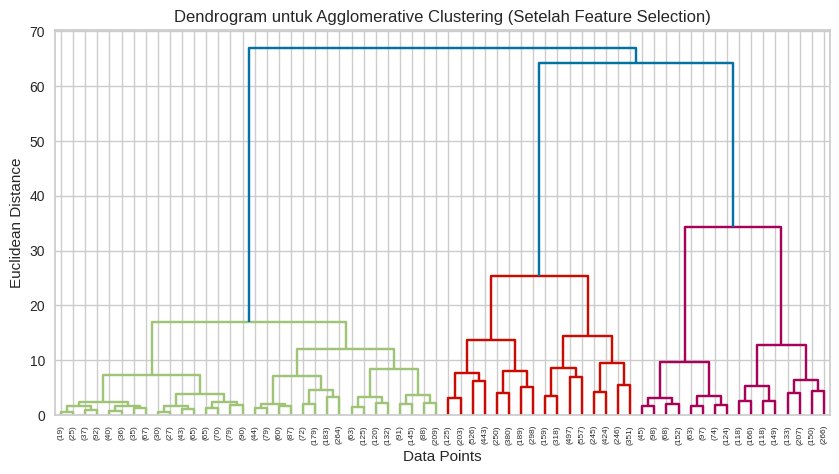

In [49]:
# --- 4. TAMPILKAN DENDROGRAM ---
plt.figure(figsize=(10, 5))
linkage_matrix = linkage(df_selected, method='ward')
dendrogram(linkage_matrix, truncate_mode="level", p=5)
plt.title("Dendrogram untuk Agglomerative Clustering (Setelah Feature Selection)")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

**Interpretasi Silhouette Score:**
- Sebelum Feature Selection: Silhouette Score 0.1095

- Setelah Feature Selection: Silhouette Score 0.5671

Hasil ini menunjukkan bahwa feature selection berhasil meningkatkan kualitas clustering, karena nilai Silhouette Score semakin mendekati 1, yang berarti cluster lebih terpisah dengan baik.

## **d. Visualisasi Hasil Clustering**

In [50]:
# --- 1. REDUKSI DIMENSI DENGAN PCA ---
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_selected)

# Tambahkan hasil PCA ke dataframe
df_cluster['PCA1'] = df_pca[:, 0]
df_cluster['PCA2'] = df_pca[:, 1]

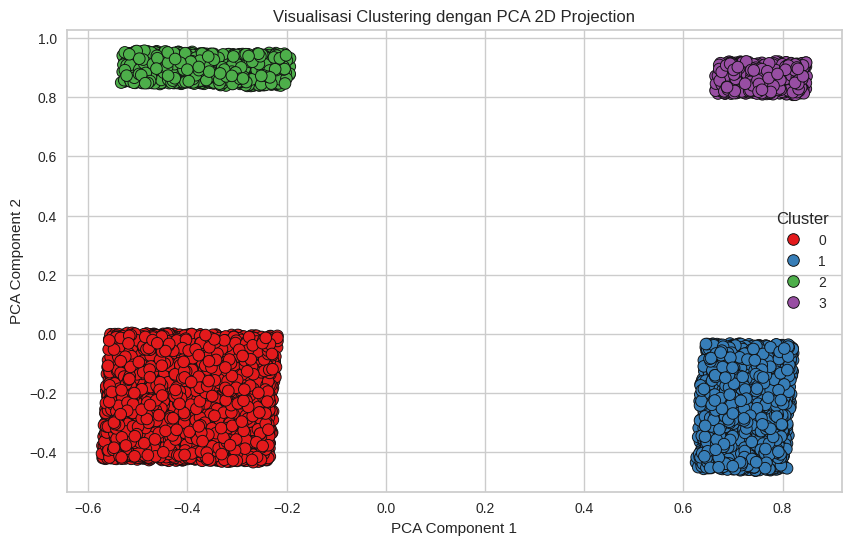

In [51]:
# --- 2. VISUALISASI CLUSTER DENGAN SCATTER PLOT ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_cluster['PCA1'], y=df_cluster['PCA2'], hue=df_cluster['Cluster'], palette='Set1', s=70, edgecolor='k')
plt.title("Visualisasi Clustering dengan PCA 2D Projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

Interpretasi Hasil Clustering
- Cluster terbentuk dengan jelas, menunjukkan pemisahan data yang efektif.

- Empat kelompok terdistribusi tanpa tumpang tindih, menandakan model menangkap pola dengan baik.

- Jarak antar cluster cukup jauh, menunjukkan pemisahan yang kuat.

- Feature selection meningkatkan kualitas clustering, terlihat dari distribusi yang lebih teratur.

## **e. Analisis dan Interpretasi Hasil Cluster**

### Analisis Cluster

####**Inverse Transform untuk Data Kategorikal**

In [52]:
print(df_selected.columns)

Index(['Video_Watching_Habit_Very Long', 'Quiz_Performance_High', 'Age',
       'Time_Spent_on_Videos', 'Quiz_Scores'],
      dtype='object')


In [53]:
# Mapping kategori yang ingin dikembalikan
category_mappings = {
    "Video_Watching_Habit": ["Video_Watching_Habit_Very Long"],
    "Quiz_Performance": ["Quiz_Performance_High"]
}

# Fungsi inverse one-hot encoding untuk kategori tertentu
def inverse_selected_one_hot(df, category_mappings):
    for category, cols in category_mappings.items():
        df[category] = np.select([df[col] for col in cols], cols, default=None)
        df[category] = df[category].str.replace(f"{category}_", "")  # Bersihkan prefix kategori
        df.drop(columns=cols, inplace=True)  # Hapus kolom one-hot setelah konversi
    return df

# Lakukan inverse transform pada df_selected
df_selected = inverse_selected_one_hot(df_selected, category_mappings)

# Cek hasilnya
print(df_selected.head())

        Age  Time_Spent_on_Videos  Quiz_Scores Video_Watching_Habit  \
0  0.000000              0.329243     0.536232                 None   
1  1.000000              0.298569     0.492754                 None   
2  0.147059              0.423313     0.362319                 None   
3  0.647059              0.979550     0.507246            Very Long   
4  0.558824              0.993865     0.420290            Very Long   

  Quiz_Performance  
0             None  
1             None  
2             None  
3             None  
4             None  


<ipython-input-53-c285ca5010f0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[category] = np.select([df[col] for col in cols], cols, default=None)
<ipython-input-53-c285ca5010f0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[category] = df[category].str.replace(f"{category}_", "")  # Bersihkan prefix kategori
<ipython-input-53-c285ca5010f0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

####  **Inverse Transform untuk Data Numerik**

In [54]:
print(df_selected.columns)

Index(['Age', 'Time_Spent_on_Videos', 'Quiz_Scores', 'Video_Watching_Habit',
       'Quiz_Performance'],
      dtype='object')


In [55]:
# Load scaler yang telah disimpan
scaler = joblib.load("scaler.pkl")

# Pastikan semua fitur numerik kembali ke skala aslinya
df[numerical_features] = scaler.inverse_transform(df[numerical_features])

# Sekarang df_selected mengambil data yang sudah di-inverse
df_selected['Final_Exam_Score'] = df['Final_Exam_Score']
df_selected['Age'] = df['Age']


<ipython-input-55-294f9eb4b850>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Final_Exam_Score'] = df['Final_Exam_Score']
<ipython-input-55-294f9eb4b850>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Age'] = df['Age']


In [56]:
df_selected.describe()

,Age,Time_Spent_on_Videos,Quiz_Scores,Final_Exam_Score
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,32.137700,0.501790,0.501139,64.697000
std,10.062647,0.289686,0.294045,20.096417
min,15.000000,0.000000,0.000000,30.000000
25%,24.000000,0.247444,0.246377,47.000000
50%,32.000000,0.505112,0.507246,65.000000
75%,41.000000,0.752556,0.753623,82.000000
max,49.000000,1.000000,1.000000,99.000000


In [57]:
df_selected["Cluster"] = df_cluster["Cluster"]

# Cek hasilnya
print(df_selected.head())

    Age  Time_Spent_on_Videos  Quiz_Scores Video_Watching_Habit  \
0  15.0              0.329243     0.536232                 None   
1  49.0              0.298569     0.492754                 None   
2  20.0              0.423313     0.362319                 None   
3  37.0              0.979550     0.507246            Very Long   
4  34.0              0.993865     0.420290            Very Long   

  Quiz_Performance  Final_Exam_Score  Cluster  
0             None              51.0        0  
1             None              92.0        0  
2             None              45.0        0  
3             None              59.0        2  
4             None              93.0        2  


<ipython-input-57-89a81df9b16c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected["Cluster"] = df_cluster["Cluster"]


In [58]:
# Grouping berdasarkan Cluster dan menghitung statistik ringkasan
cluster_summary = df_selected.groupby("Cluster").agg({
    "Age": ["mean", "std", "min", "max", "count"],
    "Time_Spent_on_Videos": ["mean", "std", "min", "max", "count"],
    "Quiz_Scores": ["mean", "std", "min", "max", "count"],
    "Final_Exam_Score": ["mean", "std", "min", "max", "count"]
})

# Menampilkan ringkasan
print(cluster_summary)

               Age                              Time_Spent_on_Videos  \
              mean        std   min   max count                 mean   
Cluster                                                                
0        32.326041  10.103239  15.0  49.0  5211             0.398966   
1        31.829772   9.907836  15.0  49.0  2761             0.404564   
2        32.315991  10.145364  15.0  49.0  1307             0.897442   
3        31.632455  10.180428  15.0  49.0   721             0.900039   

                                            Quiz_Scores                      \
              std       min       max count        mean       std       min   
Cluster                                                                       
0        0.233882  0.000000  0.797546  5211    0.324511  0.192732  0.000000   
1        0.230679  0.000000  0.797546  2761    0.833194  0.098355  0.666667   
2        0.059418  0.799591  1.000000  1307    0.320127  0.190243  0.000000   
3        0.058717  0.

### Interpretasi Cluster

**Interpretasi Cluster**

**Cluster 0 (52.1%) - Kelompok Pasif**
- Rata-rata Usia (0-100) : 32.3

- Rata-rata Waktu Menonton Video (0-1) : 0.40

- Rata-rata Skor Kuis (0-1) : 32.4

- Rata-rata Nilai Ujian Akhir (0-100) : 64.7

Kelompok terbesar ini memiliki kebiasaan belajar yang relatif pasif. Mereka tidak banyak menonton video dan memiliki skor kuis yang rendah. Namun, nilai ujian akhir mereka masih cukup stabil.

**Cluster 1 (27.6%) - Kelompok Mandiri**
- Rata-rata Usia (0-100) : 31.8

- Rata-rata Waktu Menonton Video (0-1) : 0.40

- Rata-rata Skor Kuis (0-1) : 83.3

- Rata-rata Nilai Ujian Akhir (0-100) : 64.8

Kelompok ini jarang menonton video tetapi aktif dalam mengerjakan kuis, sehingga memiliki skor kuis yang sangat tinggi. Meski begitu, nilai ujian akhir mereka tidak jauh berbeda dari kelompok lainnya.

**Cluster 2 (13.1%) - Kelompok Konsumtif**
- Rata-rata Usia (0-100) : 32.3

- Rata-rata Waktu Menonton Video (0-1) : 0.90

- Rata-rata Skor Kuis (0-1) : 32.0

- Rata-rata Nilai Ujian Akhir (0-100) : 64.5

Kelompok ini banyak menonton video, tetapi tidak aktif mengerjakan kuis, yang menyebabkan skor kuis mereka rendah.

**Cluster 3 (7.2%) - Kelompok Optimal**
- Rata-rata Usia (0-100) : 31.6

- Rata-rata Waktu Menonton Video (0-1) : 0.90

- Rata-rata Skor Kuis (0-1) : 83.4

- Rata-rata Nilai Ujian Akhir (0-100) : 64.7

Kelompok ini memiliki kebiasaan belajar paling optimal. Mereka sering menonton video dan aktif mengerjakan kuis, sehingga memiliki skor kuis yang sangat tinggi.



# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [59]:
df_selected.head()

,Age,Time_Spent_on_Videos,Quiz_Scores,Video_Watching_Habit,Quiz_Performance,Final_Exam_Score,Cluster
0,15.0,0.329243,0.536232,None,None,51.0,0
1,49.0,0.298569,0.492754,None,None,92.0,0
2,20.0,0.423313,0.362319,None,None,45.0,0
3,37.0,0.979550,0.507246,Very Long,None,59.0,2
4,34.0,0.993865,0.420290,Very Long,None,93.0,2


In [60]:
df_selected.to_csv("clustered_data_for_classification.csv", index=False)